
SumSquares: 2D


In [ ]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 27.9 MB/s 
     |████████████████████████████████| 872 kB 60.3 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=2eea21fc4682928d7c8dc0c1306ee32c87b5e32243c5d180e8310864a54a9cd8
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=0495eb842ba054d601cf4dbad54bb0b48586358d1d99d1d926f1d4738b5ce344
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [ ]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import t
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [ ]:
### Inputs:

func = 'SumSquares'
n_test = 500
eps = 1e-08

util = 'CBM'

n_init = 5 # random initialisations
iters = 20
opt = True

df = 3

In [ ]:
### Objective Function - Sum Squares(x) 2-D:

def objfunc(x1_training, x2_training):
            return  operator * (  1 * x1_training ** 2
                            + 2 * x2_training ** 2
                            )
        
# Constraints:
lb = -5.12
ub = +5.12
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
                 'x2_training': ('cont', [lb, ub])
                 }
    
# True y bounds:
y_lb = 0
operator = -1 # targets global minimum 
y_global_orig = y_lb * operator # targets global minimum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
x_test = np.column_stack((x1_test, x2_test))

In [ ]:
n_start_AcqFunc = iters
inverse = -1


In [ ]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [ ]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dtStudentProcess(tStudentProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the STP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        
        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)

        alpha = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), self.y)
        alpha_Kstar = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)      
        
        dm = np.dot(dKstar, alpha)
        ds = -2 * smd_adj * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds          


In [ ]:
### Add exact acquisition function gradient as attribute:

Beta_CBM = dim

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM': self.CBM
        }

        self.f = mode_dict[mode]
    
    def CBM(self, y_global_orig, mean, std, ds, dm, nu=3.0):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, y_global_orig, mean, std, ds, dm, nu=3.0):
    
        return self.f(y_global_orig, mean, std, ds, dm, nu=3.0, **self.params)
        

In [ ]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact CBM: StdDev. x \t Approx CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.x_best_std)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.x_best_std_exact = np.std(x_best_exact)
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_exact)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_exact = str(self.f_best_min_exact)
        x_best_std = str(self.x_best_std)
        x_best_std_exact = str(self.x_best_std_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_exact = BOLD + OKGREEN + x_best_std_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std_exact, x_best_std))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [ ]:
## dGPGO:

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact CBM: StdDev. x \t Approx CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.x_best_std_approx = np.std(x_best_approx)
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_approx)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_approx = str(self.f_best_min_approx)
        x_best_std = str(self.x_best_std)
        x_best_std_approx = str(self.x_best_std_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_approx = BOLD + OKGREEN + x_best_std_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [ ]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [ ]:
start_approx = time.time()
start_approx


1662465562.3333569

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_grad(util), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.84969467  2.25612281]	 10.902161328666502	 1.4334486961549602	    	    
init	 [-5.1188288  -2.02411446]	 34.396486966857985	 1.4334486961549602	    	    
init	 [-3.61721968 -4.17445279]	 47.936390383803385	 1.4334486961549602	    	    
init	 [-3.21269544 -1.58145816]	 15.323431753768267	 1.4334486961549602	    	    
init	 [-1.05710106  0.39748336]	 1.4334486961549602	 1.4334486961549602	    	    
1  	 [ 5.12       -2.90720813]	 43.11811824087371	 1.4334486961549602	 3.7008731761352043	 4.308503513506956
2  	 [5.12 5.12]	 78.64320000000001	 1.4334486961549602	 3.3691934822803735	 4.13815094883741
3  	 [-5.12  5.12]	 78.64320000000001	 1.4334486961549602	 3.4044547597965313	 4.001945674741267
4  	 [ 1.00458103 -5.12      ]	 53.43798304970471	 1.4334486961549602	 3.594136566504537	 3.822125614950249
5  	 [3.06280222 0.98369391]	 11.316064873773257	 1.4334486961549602

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_grad(util), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.6554122  -4.85451539]	 47.562204422038214	 1.1358959044973735	    	    
init	 [ 0.50854377 -0.6622987 ]	 1.1358959044973735	 1.1358959044973735	    	    
init	 [-0.81543371 -1.73737143]	 6.7018511217540135	 1.1358959044973735	    	    
init	 [-3.02439799  1.2213347 ]	 12.13030006303276	 1.1358959044973735	    	    
init	 [-2.05153614 -2.3876887 ]	 15.610915224537823	 1.1358959044973735	    	    
1  	 [4.81874241 3.07464552]	 42.12716849729408	 1.1358959044973735	 3.7226596370893485	 3.835848750447288
2  	 [ 5.00937588 -3.41761904]	 48.454086575425194	 1.1358959044973735	 3.069693897993094	 4.199978113240532
3  	 [-0.02531714  5.12      ]	 52.4294409576998	 1.1358959044973735	 3.723297418269045	 4.054278686248882
4  	 [-5.12  5.12]	 78.64320000000001	 1.1358959044973735	 3.5258873344241173	 3.8498634595425942
5  	 [-5.12 -5.12]	 78.64320000000001	 1.135895904497373

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_grad(util), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.52017052 2.1314337 ]	 9.356596638100186	 4.609047504113831	    	    
init	 [-2.14113547  0.11087468]	 4.609047504113831	 4.609047504113831	    	    
init	 [4.02377681 4.05804123]	 49.12617709674532	 4.609047504113831	    	    
init	 [-3.83400642 -2.99783293]	 32.673609761904345	 4.609047504113831	    	    
init	 [-4.59297584 -0.6061072 ]	 21.83015892853491	 4.609047504113831	    	    
1  	 [ 2.87042319 -1.98283743]	 16.10261781709846	 4.609047504113831	 2.454203329719728	 2.784935737557771
2  	 [-5.12  5.12]	 78.64320000000001	 4.609047504113831	 3.052186077262988	 4.345419574088326
3  	 [ 0.06925401 -5.12      ]	 52.43359611753947	 4.609047504113831	 3.2267171135192525	 4.070674857687113
4  	 [ 5.12 -5.12]	 78.64320000000001	 4.609047504113831	 3.234038278696004	 3.4058853827307334
5  	 [-0.94966383  5.12      ]	 53.33066139648062	 4.609047504113831	 3.31594009203

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_4= GPGO_multi(surrogate_approx_4, Acquisition_grad(util), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [4.78238555 0.48365823]	 23.33906213310676	 7.289910254474112	    	    
init	 [4.84028785 2.19971578]	 33.10588541607836	 7.289910254474112	    	    
init	 [ 2.02474316 -2.90724357]	 21.003715175118646	 7.289910254474112	    	    
init	 [ 4.87705042 -5.05620219]	 74.91598187475032	 7.289910254474112	    	    
init	 [-2.52946061 -0.66773471]	 7.289910254474112	 7.289910254474112	    	    
1  	 [-5.12  5.12]	 78.64320000000001	 7.289910254474112	 2.911853035769714	 3.957358657366278
2  	 [-5.12 -5.12]	 78.64320000000001	 7.289910254474112	 3.7033608532828834	 4.127054920692203
3  	 [0.40334993 5.12      ]	 52.59149116636695	 7.289910254474112	 3.3945124289616815	 3.622577432180124
4	 [0.70938836 0.95200511]	 2.31585929075122	 2.31585929075122	 3.2047524249120656	 3.333452466228626
5  	 [-0.97430202 -5.12      ]	 53.378064433318656	 2.31585929075122	 2.9982248292856992	 

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_grad(util), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.84678993  3.79629882]	 36.927982283829365	 2.6327313115208373	    	    
init	 [-3.00319585  4.2865757 ]	 45.76864772649561	 2.6327313115208373	    	    
init	 [-0.11866943  1.14425716]	 2.6327313115208373	 2.6327313115208373	    	    
init	 [2.72289645 0.1886002 ]	 7.485305147100433	 2.6327313115208373	    	    
init	 [-2.08076286 -3.19773462]	 24.780587476435763	 2.6327313115208373	    	    
1  	 [ 5.12       -4.92049497]	 74.63694147045135	 2.6327313115208373	 4.51748771961911	 4.75216973814078
2  	 [5.12 5.12]	 78.64320000000001	 2.6327313115208373	 4.22186754729349	 4.188673839204824
3  	 [-5.12      -0.0409718]	 26.217757377421762	 2.6327313115208373	 3.608532108370981	 3.868908355167205
4  	 [0.97508388 5.12      ]	 53.379588572805794	 2.6327313115208373	 3.394125535267154	 3.4631581107392484
5  	 [-5.12 -5.12]	 78.64320000000001	 2.6327313115208373	 3.37783

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_grad(util), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 4.02288795 -1.72052679]	 22.104052359713652	 1.4757178799086357	    	    
init	 [ 3.28938622 -4.69302655]	 54.869058151382724	 1.4757178799086357	    	    
init	 [-4.0175956   0.97333314]	 18.035829177697114	 1.4757178799086357	    	    
init	 [ 0.30532979 -0.83141193]	 1.4757178799086357	 1.4757178799086357	    	    
init	 [-1.68542362  1.25459899]	 5.988690020231891	 1.4757178799086357	    	    
1  	 [5.12 5.12]	 78.64320000000001	 1.4757178799086357	 3.8637534665207807	 3.932533092991315
2  	 [-5.12 -5.12]	 78.64320000000001	 1.4757178799086357	 3.744717503864099	 3.757856537945605
3  	 [0.07227341 5.12      ]	 52.43402344513565	 1.4757178799086357	 3.07624443101288	 3.4932767014874293
4  	 [-5.12  5.12]	 78.64320000000001	 1.4757178799086357	 3.1062860635083536	 4.174338428033953
5  	 [-0.93221325 -4.09631561]	 34.42862473658335	 1.4757178799086357	 2.6305088329

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_grad(util), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.33860312  2.86636843]	 35.25561298730891	 5.622520458601941	    	    
init	 [-0.63068947  2.28828342]	 10.870251237170722	 5.622520458601941	    	    
init	 [4.8946126  0.39419771]	 24.268016205804518	 5.622520458601941	    	    
init	 [ 0.01147355 -4.38219639]	 38.407422120416236	 5.622520458601941	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622520458601941	 5.622520458601941	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 5.622520458601941	 3.4821722731430476	 3.8163407939490197
2  	 [ 5.12 -5.12]	 78.64320000000001	 5.622520458601941	 3.7292951581762575	 4.067586540345629
3  	 [3.47854196 5.12      ]	 64.52905415560721	 5.622520458601941	 3.8532831697684626	 3.9677763654022202
4  	 [-4.02558214 -1.33646422]	 19.777584798449002	 5.622520458601941	 2.8874312064561107	 3.046307140328312
5	 [ 1.31259082 -0.73588243]	 2.8059405728082196	 2.8059405728082196

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_grad(util), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [3.82391708 4.79785639]	 60.661193695854244	 0.1518306274298758	    	    
init	 [3.78055209 0.31596228]	 14.492238445440277	 0.1518306274298758	    	    
init	 [-2.73686192 -5.00327624]	 57.555959528959804	 0.1518306274298758	    	    
init	 [-0.7119993  -0.99992207]	 2.506631309190485	 0.1518306274298758	    	    
init	 [ 0.23218863 -0.22126801]	 0.1518306274298758	 0.1518306274298758	    	    
1  	 [-0.62940142  2.80166871]	 16.094841313270745	 0.1518306274298758	 3.1817043261519435	 3.8867192708299823
2  	 [ 5.12 -5.12]	 78.64320000000001	 0.1518306274298758	 3.3146082005358695	 4.048711489553452
3  	 [-5.12  5.12]	 78.64320000000001	 0.1518306274298758	 3.2009243813527104	 3.6910924415399116
4  	 [-5.12       -0.23144435]	 26.321532973900258	 0.1518306274298758	 3.4397571530985886	 3.3803083570276122
5  	 [ 1.25050486 -3.61718884]	 27.731872619857267	 0.1518306274

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_grad(util), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-5.01376866  0.01919582]	 25.138613177506063	 14.00341364504739	    	    
init	 [-0.04328148 -3.74958562]	 28.12065798163534	 14.00341364504739	    	    
init	 [-3.66478248 -2.88195916]	 30.04200788009657	 14.00341364504739	    	    
init	 [-0.83447623 -2.57944404]	 14.00341364504739	 14.00341364504739	    	    
init	 [-4.25922917 -1.58209393]	 23.14707552082245	 14.00341364504739	    	    
1  	 [3.11029524 4.9495987 ]	 58.67099112867045	 14.00341364504739	 2.9657938657145837	 3.0418132774937487
2  	 [ 5.12       -0.72642137]	 27.269776012686833	 14.00341364504739	 3.5644401887858606	 4.212181321032368
3  	 [-2.7977129  5.12     ]	 60.25599744402073	 14.00341364504739	 2.7487965256009033	 4.465598874362273
4  	 [ 4.67588656 -5.12      ]	 74.29271509822388	 14.00341364504739	 3.197172893390827	 3.8517039249276372
5	 [0.16317133 1.40713756]	 3.9866970917037614	 3.98669

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_grad(util), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.77832339 -4.90750004]	 55.886194099964676	 14.855028828430257	    	    
init	 [1.36855793 2.54775176]	 14.855028828430257	 14.855028828430257	    	    
init	 [-0.01528819 -2.81808235]	 15.883409988980564	 14.855028828430257	    	    
init	 [-3.09183626  2.66783449]	 23.79413325191142	 14.855028828430257	    	    
init	 [-3.38830503 -4.2154003 ]	 47.019810427389544	 14.855028828430257	    	    
1  	 [ 5.12       -0.36643785]	 26.482953400284657	 14.855028828430257	 3.4854530164065554	 3.942613187658114
2  	 [5.12 5.12]	 78.64320000000001	 14.855028828430257	 3.2266554167572647	 3.9888325459139544
3  	 [-5.12       -0.57737119]	 26.88111498989883	 14.855028828430257	 3.0379415072888256	 3.6171185724241632
4  	 [-0.64644414  5.12      ]	 52.84669003103518	 14.855028828430257	 3.583395978493692	 3.7885536798541515
5  	 [-5.12  5.12]	 78.64320000000001	 14.855028828430

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_grad(util), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.27403839 -4.92057353]	 59.14341502486697	 0.7122141741228657	    	    
init	 [-0.37664229  2.30332343]	 10.752457105378047	 0.7122141741228657	    	    
init	 [-0.81711509 -0.14922651]	 0.7122141741228657	 0.7122141741228657	    	    
init	 [-4.98912446 -0.12931474]	 24.924807467825406	 0.7122141741228657	    	    
init	 [4.52410012 3.59214172]	 46.27444610017016	 0.7122141741228657	    	    
1  	 [ 3.03550212 -4.46785095]	 49.13765732819627	 0.7122141741228657	 3.103655133725172	 4.041555293912765
2  	 [-5.12  5.12]	 78.64320000000001	 0.7122141741228657	 2.4117549523360466	 3.5977815741522083
3  	 [ 5.12       -0.69370485]	 27.176852826073812	 0.7122141741228657	 3.1034414236699917	 3.54601110487995
4  	 [1.02080747 5.12      ]	 53.47084788708138	 0.7122141741228657	 2.880011810594152	 2.6981249641364133
5  	 [-0.19478452 -2.6049917 ]	 13.609904490119312	 0.7122

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_grad(util), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.54137249  2.45810889]	 24.62591779447066	 6.112828495563743	    	    
init	 [-2.42365424  0.34549139]	 6.112828495563743	 6.112828495563743	    	    
init	 [-4.97075238  4.28796936]	 61.48174177959852	 6.112828495563743	    	    
init	 [ 4.10332011 -4.77776458]	 62.49130467854858	 6.112828495563743	    	    
init	 [ 4.6791612  -3.71497655]	 49.4966510918416	 6.112828495563743	    	    
1  	 [5.12 5.12]	 78.64320000000001	 6.112828495563743	 3.705251380733214	 3.4957259451711327
2  	 [-5.12 -5.12]	 78.64320000000001	 6.112828495563743	 3.519141116263808	 3.112048825021908
3  	 [2.22918476 0.7680363 ]	 6.1490242043928705	 6.112828495563743	 2.792050784746846	 2.6224191083210973
4  	 [0.21517029 5.12      ]	 52.475098254678194	 6.112828495563743	 3.041062297267091	 3.202313131322271
5  	 [-0.49940319 -3.56827081]	 25.714516690783572	 6.112828495563743	 2.735735599327

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_grad(util), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.84367268 -2.68757791]	 22.532624345992815	 12.440151302029248	    	    
init	 [3.32061217 4.76927179]	 56.51837198799	 12.440151302029248	    	    
init	 [ 4.83943541 -0.47667971]	 23.87458213765974	 12.440151302029248	    	    
init	 [1.11659482 2.82139151]	 17.16728408945556	 12.440151302029248	    	    
init	 [1.45012065 2.27346667]	 12.440151302029248	 12.440151302029248	    	    
1  	 [-5.12       -2.69938019]	 40.787706827059935	 12.440151302029248	 2.871504288395826	 3.3454660409485433
2  	 [-5.12  5.12]	 78.64320000000001	 12.440151302029248	 3.2188570910201544	 3.7259403405012215
3  	 [-1.05402319 -5.12      ]	 53.53976489293123	 12.440151302029248	 3.2204773736742665	 3.2948738636368384
4	 [-2.75708765  1.04858556]	 9.800595671128116	 9.800595671128116	 2.997987354530074	 3.0240732250412172
5  	 [ 5.12 -5.12]	 78.64320000000001	 9.800595671128116	 3.5912

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_grad(util), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.14277984 2.79721013]	 15.669155142359655	 6.942951853664133	    	    
init	 [ 3.7931795  -5.03759925]	 65.14302308089468	 6.942951853664133	    	    
init	 [-1.94830412  4.68586229]	 47.71049977745547	 6.942951853664133	    	    
init	 [ 0.13431513 -1.86076749]	 6.942951853664133	 6.942951853664133	    	    
init	 [ 0.40140736 -2.85434939]	 16.455748743182696	 6.942951853664133	    	    
1  	 [-5.12       -4.49908786]	 66.69798314085202	 6.942951853664133	 4.219686036856204	 4.014623713127529
2  	 [5.12 5.12]	 78.64320000000001	 6.942951853664133	 3.782650348167301	 3.976783962286868
3  	 [-5.12        0.70595047]	 27.211132134936847	 6.942951853664133	 2.680239158904505	 3.7318637112026978
4  	 [ 5.12       -0.06608531]	 26.223134537303554	 6.942951853664133	 2.943947331209711	 3.3924680989443923
5	 [-1.80330738  0.04506138]	 3.2559785792659124	 3.2559785792659124

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 3.57189322 -3.28810573]	 34.38169974295086	 5.478261179905657	    	    
init	 [-4.56332069 -1.41784631]	 24.84447200795673	 5.478261179905657	    	    
init	 [-2.29989449  0.3072023 ]	 5.478261179905657	 5.478261179905657	    	    
init	 [-1.9873903  -2.00218256]	 11.967190241167383	 5.478261179905657	    	    
init	 [-3.97576933 -2.5610341 ]	 28.924533081850157	 5.478261179905657	    	    
1  	 [1.30790741 5.12      ]	 54.13942179666498	 5.478261179905657	 3.8296105266238385	 3.7699509812204055
2  	 [-5.12        4.81531315]	 72.5888815154362	 5.478261179905657	 3.8567526862457955	 3.946850572694795
3  	 [5.12       1.62319389]	 31.483916831132543	 5.478261179905657	 3.46789496853045	 3.6855122819819606
4  	 [-0.10739845 -5.12      ]	 52.440334426817145	 5.478261179905657	 2.9688698551574557	 3.008575166779197
5	 [1.25302878 0.46100349]	 1.9951295590777067	 1.99512

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_grad(util), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.83349935  0.23719262]	 8.141239237549925	 8.141239237549925	    	    
init	 [ 0.51918292 -4.65303603]	 43.571039504503474	 8.141239237549925	    	    
init	 [-1.42613673 -2.83565116]	 18.11570093066862	 8.141239237549925	    	    
init	 [ 1.9325559  -3.44339021]	 27.448644544199137	 8.141239237549925	    	    
init	 [-4.39987336  4.51595121]	 60.146516261103784	 8.141239237549925	    	    
1  	 [4.90017985 5.12      ]	 76.44056254623112	 8.141239237549925	 3.8343136723027977	 4.057916071780106
2  	 [5.12       0.06914705]	 26.223962628947547	 8.141239237549925	 3.7887413141734156	 3.7972980152080154
3  	 [0.42926254 3.22181829]	 20.94449255722095	 8.141239237549925	 3.5155305092519646	 3.9904509619365327
4  	 [-5.12 -5.12]	 78.64320000000001	 8.141239237549925	 3.7083175192647557	 3.7639253771421117
5  	 [ 5.12 -5.12]	 78.64320000000001	 8.141239237549925	 2.63414

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_grad(util), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.10263037  0.31320838]	 4.617253458637031	 3.1817562258207746	    	    
init	 [-3.15882714 -4.42470033]	 49.134134969019556	 3.1817562258207746	    	    
init	 [2.93873111 1.60085526]	 13.761615685279608	 3.1817562258207746	    	    
init	 [1.40821398 0.77417363]	 3.1817562258207746	 3.1817562258207746	    	    
init	 [-4.71999574 -1.45598869]	 26.518165900202685	 3.1817562258207746	    	    
1  	 [ 5.12 -5.12]	 78.64320000000001	 3.1817562258207746	 3.3124002570611535	 4.521532914153033
2  	 [-4.04311999  5.12      ]	 68.77561928558156	 3.1817562258207746	 3.2673789886399436	 3.3583273438557297
3  	 [5.12 5.12]	 78.64320000000001	 3.1817562258207746	 3.40901165188645	 3.1143801702918688
4  	 [0.48137339 5.12      ]	 52.66052034515618	 3.1817562258207746	 3.1905208393556004	 3.499386971123073
5  	 [ 1.08129633 -2.92136458]	 18.237943725855324	 3.1817562258207746	 2

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_grad(util), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [1.53983224 0.05584255]	 2.3773200933391867	 2.3773200933391867	    	    
init	 [ 3.87687906 -3.25795609]	 36.25874706055664	 2.3773200933391867	    	    
init	 [3.60686662 2.56139557]	 26.130981366974602	 2.3773200933391867	    	    
init	 [1.70088108 4.99604939]	 52.81401545301259	 2.3773200933391867	    	    
init	 [-2.48864335 -4.83014733]	 52.85399210258478	 2.3773200933391867	    	    
1  	 [-5.00718904  2.9174042 ]	 42.09443666312248	 2.3773200933391867	 3.2363171628541774	 4.065114789558744
2  	 [-2.12752533 -0.37507151]	 4.8077213032073844	 2.3773200933391867	 3.2324857221981103	 2.81837494631944
3  	 [-5.12       -1.67664502]	 31.836677075735444	 2.3773200933391867	 3.750377996585655	 3.5590363508095404
4  	 [-2.08575083  5.12      ]	 56.77915653467837	 2.3773200933391867	 3.1168856506816307	 3.718493785486317
5  	 [ 0.33164984 -2.48846061]	 12.4948640687153

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_grad(util), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.12125592  2.6751971 ]	 31.298109376682206	 22.814458446152262	    	    
init	 [-2.59135515 -3.70553152]	 34.17704923320956	 22.814458446152262	    	    
init	 [-1.72598719 -4.27008445]	 39.4462742815243	 22.814458446152262	    	    
init	 [1.76104531 3.13952049]	 22.814458446152262	 22.814458446152262	    	    
init	 [4.9432772  1.38916592]	 28.295553455390152	 22.814458446152262	    	    
1  	 [ 5.12 -5.12]	 78.64320000000001	 22.814458446152262	 3.389631312490309	 4.608586619639158
2	 [ 1.73294707 -1.56670984]	 7.912265025051298	 7.912265025051298	 3.774582829505814	 3.3838340444867496
3  	 [5.12 5.12]	 78.64320000000001	 7.912265025051298	 3.8280631937520084	 4.238801426180572
4  	 [-5.12       -1.02141265]	 28.300967605740638	 7.912265025051298	 2.8017162845755124	 3.0107551498837575
5	 [-1.1395048   0.27619525]	 1.4510388281318916	 1.4510388281318916	 2.87612

In [ ]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_grad(util), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.9024594  4.07258857]	 33.98638835688907	 1.615187047660523	    	    
init	 [4.00927467 3.23417577]	 36.994069169927414	 1.615187047660523	    	    
init	 [-4.75249064  1.96359764]	 30.297598676217497	 1.615187047660523	    	    
init	 [-1.24230715  0.18955208]	 1.615187047660523	 1.615187047660523	    	    
init	 [ 1.61742301 -3.13497377]	 22.27217824772924	 1.615187047660523	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 1.615187047660523	 3.534310179294596	 3.977368494070362
2  	 [ 5.12 -5.12]	 78.64320000000001	 1.615187047660523	 3.1128428897463927	 3.860227781120881
3  	 [ 5.12       -0.73705015]	 27.300885841306215	 1.615187047660523	 2.93971583913174	 2.9319706775150665
4  	 [-2.84848547  5.12      ]	 60.54266944560388	 1.615187047660523	 2.970093282324093	 3.6026428274025943
5  	 [-2.11314428 -2.55486989]	 17.520099078516864	 1.615187047660523	 2.89178859

In [ ]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1662466157.318701

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_grad(util), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.84969467  2.25612281]	 10.902161328666502	 1.4334486961549602	    	    
init	 [-5.1188288  -2.02411446]	 34.396486966857985	 1.4334486961549602	    	    
init	 [-3.61721968 -4.17445279]	 47.936390383803385	 1.4334486961549602	    	    
init	 [-3.21269544 -1.58145816]	 15.323431753768267	 1.4334486961549602	    	    
init	 [-1.05710106  0.39748336]	 1.4334486961549602	 1.4334486961549602	    	    
1  	 [ 4.04077223 -4.24914728]	 52.43834538835027	 1.4334486961549602	 3.7008731761352043	 4.308503513506956
2  	 [5.12 5.12]	 78.64320000000001	 1.4334486961549602	 3.2296960528158887	 3.551477121156901
3  	 [4.70959273 0.38076147]	 22.47022227922834	 1.4334486961549602	 3.4012025724917923	 4.153066983578914
4  	 [-4.8996706   4.58713035]	 66.09030177989149	 1.4334486961549602	 3.753158524940357	 4.158527482448192
5  	 [ 0.63590327 -1.966432  ]	 8.13808255715953	 1.43344

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_grad(util), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.6554122  -4.85451539]	 47.562204422038214	 1.1358959044973735	    	    
init	 [ 0.50854377 -0.6622987 ]	 1.1358959044973735	 1.1358959044973735	    	    
init	 [-0.81543371 -1.73737143]	 6.7018511217540135	 1.1358959044973735	    	    
init	 [-3.02439799  1.2213347 ]	 12.13030006303276	 1.1358959044973735	    	    
init	 [-2.05153614 -2.3876887 ]	 15.610915224537823	 1.1358959044973735	    	    
1  	 [4.81874241 3.07464552]	 42.12716849729408	 1.1358959044973735	 3.7226596370893485	 3.835848750447288
2  	 [ 4.84261953 -3.96515749]	 54.8959117832305	 1.1358959044973735	 3.069693897993094	 4.199978113240532
3  	 [0.02398058 5.12      ]	 52.42937506833584	 1.1358959044973735	 3.7073188099026804	 3.991128579468028
4  	 [-5.12 -5.12]	 78.64320000000001	 1.1358959044973735	 3.58783345048451	 4.129516925606676
5  	 [ 3.30320273 -0.43579782]	 11.290987730972526	 1.1358959

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_grad(util), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.52017052 2.1314337 ]	 9.356596638100186	 4.609047504113831	    	    
init	 [-2.14113547  0.11087468]	 4.609047504113831	 4.609047504113831	    	    
init	 [4.02377681 4.05804123]	 49.12617709674532	 4.609047504113831	    	    
init	 [-3.83400642 -2.99783293]	 32.673609761904345	 4.609047504113831	    	    
init	 [-4.59297584 -0.6061072 ]	 21.83015892853491	 4.609047504113831	    	    
1  	 [ 2.87042319 -1.98283743]	 16.10261781709846	 4.609047504113831	 2.454203329719728	 2.784935737557771
2  	 [-3.58469501  4.79950486]	 58.920532130898565	 4.609047504113831	 3.052186077262988	 4.345419574088326
3  	 [-0.39551444 -2.39689456]	 11.646638720636432	 4.609047504113831	 3.1474051308692466	 3.760761862143678
4  	 [ 1.6766048 -5.12     ]	 55.23980364234088	 4.609047504113831	 3.2561345131592376	 3.6386558070091573
5  	 [5.12       0.65821962]	 27.08090614243154	 4.6090475

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_grad(util), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [4.78238555 0.48365823]	 23.33906213310676	 7.289910254474112	    	    
init	 [4.84028785 2.19971578]	 33.10588541607836	 7.289910254474112	    	    
init	 [ 2.02474316 -2.90724357]	 21.003715175118646	 7.289910254474112	    	    
init	 [ 4.87705042 -5.05620219]	 74.91598187475032	 7.289910254474112	    	    
init	 [-2.52946061 -0.66773471]	 7.289910254474112	 7.289910254474112	    	    
1  	 [-1.26606945  4.52370831]	 42.53080554642616	 7.289910254474112	 2.911853035769714	 3.957358657366278
2  	 [-5.12 -5.12]	 78.64320000000001	 7.289910254474112	 4.057189530079434	 3.948371912259761
3  	 [-0.97513937 -5.12      ]	 53.37969679195487	 7.289910254474112	 3.4741121841298286	 3.946837378443629
4	 [0.60949718 1.13165908]	 2.9327913630252374	 2.9327913630252374	 3.105584141256655	 3.5711693407958314
5  	 [-5.12        2.31703282]	 36.951682200431904	 2.9327913630252374	 2

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_grad(util), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.84678993  3.79629882]	 36.927982283829365	 2.6327313115208373	    	    
init	 [-3.00319585  4.2865757 ]	 45.76864772649561	 2.6327313115208373	    	    
init	 [-0.11866943  1.14425716]	 2.6327313115208373	 2.6327313115208373	    	    
init	 [2.72289645 0.1886002 ]	 7.485305147100433	 2.6327313115208373	    	    
init	 [-2.08076286 -3.19773462]	 24.780587476435763	 2.6327313115208373	    	    
1  	 [ 4.32895605 -5.09732646]	 70.70533460957368	 2.6327313115208373	 4.51748771961911	 4.75216973814078
2  	 [5.12 5.12]	 78.64320000000001	 2.6327313115208373	 4.197146802268095	 3.8260880921945453
3  	 [-5.08353844 -0.23562554]	 25.953401827140652	 2.6327313115208373	 3.4589051367067762	 3.747047563233749
4  	 [1.05783448 4.86805732]	 48.514977981807014	 2.6327313115208373	 3.432411230607743	 3.455897423374857
5  	 [-5.12 -5.12]	 78.64320000000001	 2.6327313115208373	 3.5

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_grad(util), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 4.02288795 -1.72052679]	 22.104052359713652	 1.4757178799086357	    	    
init	 [ 3.28938622 -4.69302655]	 54.869058151382724	 1.4757178799086357	    	    
init	 [-4.0175956   0.97333314]	 18.035829177697114	 1.4757178799086357	    	    
init	 [ 0.30532979 -0.83141193]	 1.4757178799086357	 1.4757178799086357	    	    
init	 [-1.68542362  1.25459899]	 5.988690020231891	 1.4757178799086357	    	    
1  	 [5.12 5.12]	 78.64320000000001	 1.4757178799086357	 3.8637534665207807	 3.932533092991315
2  	 [-5.12 -5.12]	 78.64320000000001	 1.4757178799086357	 3.744717503864099	 3.757856537945605
3  	 [0.07826141 5.12      ]	 52.434924848072036	 1.4757178799086357	 3.07624443101288	 3.4932767014874293
4  	 [-0.88950003 -4.39340644]	 39.39525065926202	 1.4757178799086357	 3.107354298387091	 4.174388198622991
5  	 [2.37800356 1.78149227]	 12.002330371570057	 1.4757178799086357	 2

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_grad(util), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.33860312  2.86636843]	 35.25561298730891	 5.622520458601941	    	    
init	 [-0.63068947  2.28828342]	 10.870251237170722	 5.622520458601941	    	    
init	 [4.8946126  0.39419771]	 24.268016205804518	 5.622520458601941	    	    
init	 [ 0.01147355 -4.38219639]	 38.407422120416236	 5.622520458601941	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622520458601941	 5.622520458601941	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 5.622520458601941	 3.4821722731430476	 3.8163407939490197
2  	 [3.5599965 5.12     ]	 65.10237505042747	 5.622520458601941	 3.7292951581762575	 4.067586540345629
3  	 [ 4.60098855 -4.08994682]	 54.62442556920254	 5.622520458601941	 3.5338832382756955	 4.064539224206781
4  	 [-4.02558214 -1.33646422]	 19.777584798449002	 5.622520458601941	 2.8877933811840957	 3.046307140328312
5	 [ 1.26968012 -0.69412519]	 2.5757071753885477	 2.5757071

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_grad(util), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [3.82391708 4.79785639]	 60.661193695854244	 0.1518306274298758	    	    
init	 [3.78055209 0.31596228]	 14.492238445440277	 0.1518306274298758	    	    
init	 [-2.73686192 -5.00327624]	 57.555959528959804	 0.1518306274298758	    	    
init	 [-0.7119993  -0.99992207]	 2.506631309190485	 0.1518306274298758	    	    
init	 [ 0.23218863 -0.22126801]	 0.1518306274298758	 0.1518306274298758	    	    
1  	 [ 4.9638213  -4.82579675]	 71.21615052930461	 0.1518306274298758	 3.1817043261519435	 3.8867192708299823
2  	 [-1.15161962  3.15654216]	 21.2537445764144	 0.1518306274298758	 3.287490724195585	 3.5389845119388195
3  	 [-5.12      -0.0227532]	 26.215435416652596	 0.1518306274298758	 3.210210114273747	 3.6256429121454694
4  	 [ 1.08908556 -4.7860345 ]	 46.99835990052029	 0.1518306274298758	 3.4225215907244877	 3.606809710966714
5  	 [1.54455205 1.75797313]	 8.56658011236906

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_grad(util), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-5.01376866  0.01919582]	 25.138613177506063	 14.00341364504739	    	    
init	 [-0.04328148 -3.74958562]	 28.12065798163534	 14.00341364504739	    	    
init	 [-3.66478248 -2.88195916]	 30.04200788009657	 14.00341364504739	    	    
init	 [-0.83447623 -2.57944404]	 14.00341364504739	 14.00341364504739	    	    
init	 [-4.25922917 -1.58209393]	 23.14707552082245	 14.00341364504739	    	    
1  	 [3.11029524 4.9495987 ]	 58.67099112867045	 14.00341364504739	 2.9657938657145837	 3.0418132774937487
2  	 [ 4.90504753 -1.17876654]	 26.838472404862035	 14.00341364504739	 3.5644401887858606	 4.212181321032368
3  	 [-1.94955     3.97847316]	 35.457242668917246	 14.00341364504739	 2.753775775318251	 4.361150169290011
4	 [1.18383481 0.90690391]	 3.046414253129643	 3.046414253129643	 3.3749087862349376	 3.878843075865125
5  	 [5.12       2.10802882]	 35.10197104411934	 3.046414

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_grad(util), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.77832339 -4.90750004]	 55.886194099964676	 14.855028828430257	    	    
init	 [1.36855793 2.54775176]	 14.855028828430257	 14.855028828430257	    	    
init	 [-0.01528819 -2.81808235]	 15.883409988980564	 14.855028828430257	    	    
init	 [-3.09183626  2.66783449]	 23.79413325191142	 14.855028828430257	    	    
init	 [-3.38830503 -4.2154003 ]	 47.019810427389544	 14.855028828430257	    	    
1  	 [ 5.12       -0.29097273]	 26.383730263933092	 14.855028828430257	 3.4854530164065554	 3.942613187658114
2  	 [5.12 5.12]	 78.64320000000001	 14.855028828430257	 3.224265956889063	 4.040945293852499
3  	 [-4.19746119 -0.70791002]	 18.62095366395573	 14.855028828430257	 2.973775351691394	 3.616184281862764
4  	 [0.31218475 5.12      ]	 52.526259317765025	 14.855028828430257	 3.5596181003999945	 4.02617894519503
5	 [ 2.05201974 -0.72277365]	 5.255588487975823	 5.255588487

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_grad(util), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.27403839 -4.92057353]	 59.14341502486697	 0.7122141741228657	    	    
init	 [-0.37664229  2.30332343]	 10.752457105378047	 0.7122141741228657	    	    
init	 [-0.81711509 -0.14922651]	 0.7122141741228657	 0.7122141741228657	    	    
init	 [-4.98912446 -0.12931474]	 24.924807467825406	 0.7122141741228657	    	    
init	 [4.52410012 3.59214172]	 46.27444610017016	 0.7122141741228657	    	    
1  	 [ 3.03550212 -4.46785095]	 49.13765732819627	 0.7122141741228657	 3.103655133725172	 4.041555293912765
2  	 [ 4.91189948 -0.58768239]	 24.81749767398038	 0.7122141741228657	 2.4117549523360466	 3.5977815741522083
3  	 [-0.33340839 -2.50917311]	 12.703060536279539	 0.7122141741228657	 3.089423546622062	 4.112464388565229
4  	 [1.77987122 0.55485576]	 3.7836714070164694	 0.7122141741228657	 2.958846229521167	 3.362921035021089
5  	 [-3.44598743  3.2109297 ]	 32.49496841708

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_grad(util), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.54137249  2.45810889]	 24.62591779447066	 6.112828495563743	    	    
init	 [-2.42365424  0.34549139]	 6.112828495563743	 6.112828495563743	    	    
init	 [-4.97075238  4.28796936]	 61.48174177959852	 6.112828495563743	    	    
init	 [ 4.10332011 -4.77776458]	 62.49130467854858	 6.112828495563743	    	    
init	 [ 4.6791612  -3.71497655]	 49.4966510918416	 6.112828495563743	    	    
1  	 [5.12 5.12]	 78.64320000000001	 6.112828495563743	 3.705251380733214	 3.4957259451711327
2  	 [-5.12 -5.12]	 78.64320000000001	 6.112828495563743	 3.519141116263808	 3.112048825021908
3  	 [2.21730335 0.79917576]	 6.193797948244724	 6.112828495563743	 2.792050784746846	 2.6224191083210973
4  	 [0.43153113 4.680876  ]	 44.00741940122867	 6.112828495563743	 3.0467026048403727	 3.201976351408077
5  	 [-0.47553297 -4.0976094 ]	 33.806937226351	 6.112828495563743	 2.730360707241258	

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_grad(util), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.84367268 -2.68757791]	 22.532624345992815	 12.440151302029248	    	    
init	 [3.32061217 4.76927179]	 56.51837198799	 12.440151302029248	    	    
init	 [ 4.83943541 -0.47667971]	 23.87458213765974	 12.440151302029248	    	    
init	 [1.11659482 2.82139151]	 17.16728408945556	 12.440151302029248	    	    
init	 [1.45012065 2.27346667]	 12.440151302029248	 12.440151302029248	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 12.440151302029248	 2.871504288395826	 3.3454660409485433
2  	 [-3.78383095  0.46019358]	 14.740932961079729	 12.440151302029248	 2.91229480575711	 3.890587748808768
3  	 [-3.12721081  5.12      ]	 62.20824742812155	 12.440151302029248	 3.2248601761999627	 3.9869401537344036
4  	 [-1.32563844 -2.6913926 ]	 16.24450551867284	 12.440151302029248	 2.922579494791531	 3.412053916189883
5  	 [ 0.6603903 -5.12     ]	 52.864915343761176	 12.440151302029

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_grad(util), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.14277984 2.79721013]	 15.669155142359655	 6.942951853664133	    	    
init	 [ 3.7931795  -5.03759925]	 65.14302308089468	 6.942951853664133	    	    
init	 [-1.94830412  4.68586229]	 47.71049977745547	 6.942951853664133	    	    
init	 [ 0.13431513 -1.86076749]	 6.942951853664133	 6.942951853664133	    	    
init	 [ 0.40140736 -2.85434939]	 16.455748743182696	 6.942951853664133	    	    
1  	 [-5.12       -4.58778325]	 68.30991022720609	 6.942951853664133	 4.219686036856204	 4.014623713127529
2  	 [5.12 5.12]	 78.64320000000001	 6.942951853664133	 3.790290316038134	 3.9733853318541397
3  	 [ 4.95177313 -0.00993447]	 24.5202544993538	 6.942951853664133	 2.6888322697411295	 3.728163958154639
4  	 [-5.12       0.6564111]	 27.076151075210632	 6.942951853664133	 2.545490775806863	 3.516587468106307
5	 [-1.73248358 -0.05869406]	 3.0083893346734416	 3.0083893346734416	 2.

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 3.57189322 -3.28810573]	 34.38169974295086	 5.478261179905657	    	    
init	 [-4.56332069 -1.41784631]	 24.84447200795673	 5.478261179905657	    	    
init	 [-2.29989449  0.3072023 ]	 5.478261179905657	 5.478261179905657	    	    
init	 [-1.9873903  -2.00218256]	 11.967190241167383	 5.478261179905657	    	    
init	 [-3.97576933 -2.5610341 ]	 28.924533081850157	 5.478261179905657	    	    
1  	 [5.12 5.12]	 78.64320000000001	 5.478261179905657	 3.8296105266238385	 3.7699509812204055
2  	 [-0.52159617  5.12      ]	 52.70086256330322	 5.478261179905657	 2.696473297602738	 3.5649296783336553
3  	 [-5.12       3.5639795]	 51.618299715800475	 5.478261179905657	 3.3753859621601228	 3.5596668682696504
4  	 [2.7607564  1.03766607]	 9.775277639040837	 5.478261179905657	 2.9778547871655374	 3.109520166832101
5  	 [-0.73563025 -5.12      ]	 52.969951859990104	 5.4782611799056

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_grad(util), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.83349935  0.23719262]	 8.141239237549925	 8.141239237549925	    	    
init	 [ 0.51918292 -4.65303603]	 43.571039504503474	 8.141239237549925	    	    
init	 [-1.42613673 -2.83565116]	 18.11570093066862	 8.141239237549925	    	    
init	 [ 1.9325559  -3.44339021]	 27.448644544199137	 8.141239237549925	    	    
init	 [-4.39987336  4.51595121]	 60.146516261103784	 8.141239237549925	    	    
1  	 [5.12     4.933839]	 74.89993460068115	 8.141239237549925	 3.8343136723027977	 4.057916071780106
2  	 [ 5.12       -0.04362498]	 26.218206277827864	 8.141239237549925	 3.788087625078202	 3.673711759595258
3  	 [0.53006503 3.19040212]	 20.63830031014445	 8.141239237549925	 3.5240705897768145	 3.9252432496404235
4  	 [-5.12 -5.12]	 78.64320000000001	 8.141239237549925	 3.7022789755232295	 3.8362321114700277
5	 [ 1.68913448 -0.14039119]	 2.892594647330247	 2.892594647330247	 2

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_grad(util), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.10263037  0.31320838]	 4.617253458637031	 3.1817562258207746	    	    
init	 [-3.15882714 -4.42470033]	 49.134134969019556	 3.1817562258207746	    	    
init	 [2.93873111 1.60085526]	 13.761615685279608	 3.1817562258207746	    	    
init	 [1.40821398 0.77417363]	 3.1817562258207746	 3.1817562258207746	    	    
init	 [-4.71999574 -1.45598869]	 26.518165900202685	 3.1817562258207746	    	    
1  	 [ 4.96008736 -4.44720822]	 64.15778856025273	 3.1817562258207746	 3.3124002570611535	 4.521532914153033
2  	 [-1.28198142  5.12      ]	 54.07227636469027	 3.1817562258207746	 3.292619918093097	 3.5001997046026427
3  	 [5.12 5.12]	 78.64320000000001	 3.1817562258207746	 3.361068698173786	 3.2657289980479756
4  	 [ 0.92434253 -3.02334333]	 19.135618956529406	 3.1817562258207746	 3.563235314245983	 3.856837034435624
5  	 [ 5.12       -0.68465866]	 27.15191497249985	 3.181756

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_grad(util), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [1.53983224 0.05584255]	 2.3773200933391867	 2.3773200933391867	    	    
init	 [ 3.87687906 -3.25795609]	 36.25874706055664	 2.3773200933391867	    	    
init	 [3.60686662 2.56139557]	 26.130981366974602	 2.3773200933391867	    	    
init	 [1.70088108 4.99604939]	 52.81401545301259	 2.3773200933391867	    	    
init	 [-2.48864335 -4.83014733]	 52.85399210258478	 2.3773200933391867	    	    
1  	 [-5.00718904  2.9174042 ]	 42.09443666312248	 2.3773200933391867	 3.2363171628541774	 4.065114789558744
2  	 [-2.13084086 -0.37607323]	 4.82334494031246	 2.3773200933391867	 3.2324857221981103	 2.81837494631944
3  	 [-1.38376331  2.93414401]	 19.133203022937828	 2.3773200933391867	 3.750429071572313	 3.5590919621375208
4  	 [-5.12       -1.68242011]	 31.87547485115728	 2.3773200933391867	 3.2551128895568295	 3.824905198835721
5  	 [ 0.21644901 -2.33795549]	 10.978921896499525

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_grad(util), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.12125592  2.6751971 ]	 31.298109376682206	 22.814458446152262	    	    
init	 [-2.59135515 -3.70553152]	 34.17704923320956	 22.814458446152262	    	    
init	 [-1.72598719 -4.27008445]	 39.4462742815243	 22.814458446152262	    	    
init	 [1.76104531 3.13952049]	 22.814458446152262	 22.814458446152262	    	    
init	 [4.9432772  1.38916592]	 28.295553455390152	 22.814458446152262	    	    
1  	 [ 4.82675179 -3.73091852]	 51.13703891504524	 22.814458446152262	 3.389631312490309	 4.608586619639158
2	 [-0.87136671  0.09066259]	 0.7757193515031686	 0.7757193515031686	 4.027545765181926	 3.7435018111334735
3  	 [5.12 5.12]	 78.64320000000001	 0.7757193515031686	 3.9768328788127603	 4.0588269084750115
4  	 [-5.12       -1.17787248]	 28.989167176886472	 0.7757193515031686	 2.9120938625029615	 3.3603104457529005
5  	 [ 1.58357484 -0.8471282 ]	 3.9429616515845636	 0.775719

In [ ]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_grad(util), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.9024594  4.07258857]	 33.98638835688907	 1.615187047660523	    	    
init	 [4.00927467 3.23417577]	 36.994069169927414	 1.615187047660523	    	    
init	 [-4.75249064  1.96359764]	 30.297598676217497	 1.615187047660523	    	    
init	 [-1.24230715  0.18955208]	 1.615187047660523	 1.615187047660523	    	    
init	 [ 1.61742301 -3.13497377]	 22.27217824772924	 1.615187047660523	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 1.615187047660523	 3.534310179294596	 3.977368494070362
2  	 [ 5.12       -0.98995265]	 28.1744124929571	 1.615187047660523	 3.1128428897463927	 3.860227781120881
3  	 [-2.70067585 -2.08351482]	 15.975718015855012	 1.615187047660523	 3.063246538994981	 3.6822963366053587
4  	 [-2.54678485  4.96998498]	 55.88761447317405	 1.615187047660523	 2.755269417961206	 3.679172623355958
5  	 [1.65667521 0.30299399]	 2.928183481563744	 1.615187047660523	 2.

In [ ]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact


997.1584377288818

In [ ]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(-approx_1.GP.y[0:n_init]),-approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(-exact_1.GP.y[0:n_init]),-exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(approx_output_1 - y_global_orig)
regret_exact_1 = np.log(exact_output_1 - y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(0.36008321648211483, -1.9499819789209825)

In [ ]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(-approx_2.GP.y[0:n_init]),-approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(-exact_2.GP.y[0:n_init]),-exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(approx_output_2 - y_global_orig)
regret_exact_2 = np.log(exact_output_2 - y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(0.12742168273537824, 0.12742168273537824)

In [ ]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(-approx_3.GP.y[0:n_init]),-approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(-exact_3.GP.y[0:n_init]),-exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(approx_output_3 - y_global_orig)
regret_exact_3 = np.log(exact_output_3 - y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(-2.0440836785092564, -2.2802732263519996)

In [ ]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(-approx_4.GP.y[0:n_init]),-approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(-exact_4.GP.y[0:n_init]),-exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(approx_output_4 - y_global_orig)
regret_exact_4 = np.log(exact_output_4 - y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(0.3253780633660455, -0.055032664347518606)

In [ ]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(-approx_5.GP.y[0:n_init]),-approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(-exact_5.GP.y[0:n_init]),-exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(approx_output_5 - y_global_orig)
regret_exact_5 = np.log(exact_output_5 - y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(0.9680218287901096, 0.17874194207467814)

In [ ]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(-approx_6.GP.y[0:n_init]),-approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(-exact_6.GP.y[0:n_init]),-exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(approx_output_6 - y_global_orig)
regret_exact_6 = np.log(exact_output_6 - y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(0.38914456963575095, -0.0526715837242174)

In [ ]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(-approx_7.GP.y[0:n_init]),-approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(-exact_7.GP.y[0:n_init]),-exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(approx_output_7 - y_global_orig)
regret_exact_7 = np.log(exact_output_7 - y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(-1.3687509765351256, 0.023419863357243588)

In [ ]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(-approx_8.GP.y[0:n_init]),-approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(-exact_8.GP.y[0:n_init]),-exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(approx_output_8 - y_global_orig)
regret_exact_8 = np.log(exact_output_8 - y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(-1.88498967264663, -1.88498967264663)

In [ ]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(-approx_9.GP.y[0:n_init]),-approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(-exact_9.GP.y[0:n_init]),-exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(approx_output_9 - y_global_orig)
regret_exact_9 = np.log(exact_output_9 - y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(-0.8568311028025981, -1.0983618517639)

In [ ]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(-approx_10.GP.y[0:n_init]),-approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(-exact_10.GP.y[0:n_init]),-exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(approx_output_10 - y_global_orig)
regret_exact_10 = np.log(exact_output_10 - y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(-0.9905387506045525, -0.19525738186085312)

In [ ]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(-approx_11.GP.y[0:n_init]),-approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(-exact_11.GP.y[0:n_init]),-exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(approx_output_11 - y_global_orig)
regret_exact_11 = np.log(exact_output_11 - y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(-0.3393766064509819, -0.3393766064509819)

In [ ]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(-approx_12.GP.y[0:n_init]),-approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(-exact_12.GP.y[0:n_init]),-exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(approx_output_12 - y_global_orig)
regret_exact_12 = np.log(exact_output_12 - y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(0.11034593024799093, -0.3356100378070017)

In [ ]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(-approx_13.GP.y[0:n_init]),-approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(-exact_13.GP.y[0:n_init]),-exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(approx_output_13 - y_global_orig)
regret_exact_13 = np.log(exact_output_13 - y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(0.5873833838142385, -0.4171193997817241)

In [ ]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(-approx_14.GP.y[0:n_init]),-approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(-exact_14.GP.y[0:n_init]),-exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(approx_output_14 - y_global_orig)
regret_exact_14 = np.log(exact_output_14 - y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(-1.8070202589112985, -0.349163633666193)

In [ ]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(-approx_15.GP.y[0:n_init]),-approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(-exact_15.GP.y[0:n_init]),-exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(approx_output_15 - y_global_orig)
regret_exact_15 = np.log(exact_output_15 - y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(0.16650548605531185, -0.7679264928228464)

In [ ]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(-approx_16.GP.y[0:n_init]),-approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(-exact_16.GP.y[0:n_init]),-exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(approx_output_16 - y_global_orig)
regret_exact_16 = np.log(exact_output_16 - y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(0.07213919061250756, -1.6236836902550458)

In [ ]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(-approx_17.GP.y[0:n_init]),-approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(-exact_17.GP.y[0:n_init]),-exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(approx_output_17 - y_global_orig)
regret_exact_17 = np.log(exact_output_17 - y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(-4.461458212393033, -0.835822899550242)

In [ ]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(-approx_18.GP.y[0:n_init]),-approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(-exact_18.GP.y[0:n_init]),-exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(approx_output_18 - y_global_orig)
regret_exact_18 = np.log(exact_output_18 - y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(-1.7986440887747168, -0.11913368547790577)

In [ ]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(-approx_19.GP.y[0:n_init]),-approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(-exact_19.GP.y[0:n_init]),-exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(approx_output_19 - y_global_orig)
regret_exact_19 = np.log(exact_output_19 - y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(0.37227973311114027, -0.5835044075335885)

In [ ]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(-approx_20.GP.y[0:n_init]),-approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(-exact_20.GP.y[0:n_init]),-exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(approx_output_20 - y_global_orig)
regret_exact_20 = np.log(exact_output_20 - y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(0.479450768952963, 0.479450768952963)

In [ ]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [ ]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [ ]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [ ]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [ ]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [ ]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [ ]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [ ]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [ ]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [ ]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [ ]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [ ]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [ ]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [ ]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [ ]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [ ]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [ ]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [ ]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [ ]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [ ]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [ ]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [ ]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [ ]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

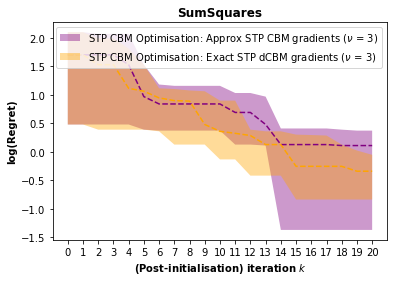

In [122]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Purple', ls='--')
plt.plot(median_exact, color = 'Orange', ls='--')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Purple', alpha=0.4, label='STP CBM Optimisation: Approx STP CBM gradients ' r'($\nu$' ' = {})'.format(df))
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Orange', alpha=0.4, label='STP CBM Optimisation: Exact STP dCBM gradients ' r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [ ]:
time_approx, time_exact


(594.9852087497711, 997.1584377288818)

In [ ]:
### acqFunc attribute x, stddev: run number = 1

acqFuncApprox_exact_1 = acqFuncApprox(exact_1.history)
acqFuncExact_exact_1 = acqFuncExact(exact_1.history)

e1 = np.mean(acqFuncExact_exact_1)
a1 = np.mean(acqFuncApprox_exact_1)

e1, a1


(3.1047501528528674, 3.4609317272266416)

In [ ]:
### acqFunc attribute x, stddev: run number = 2

acqFuncApprox_exact_2 = acqFuncApprox(exact_2.history)
acqFuncExact_exact_2 = acqFuncExact(exact_2.history)

e2 = np.mean(acqFuncExact_exact_2)
a2 = np.mean(acqFuncApprox_exact_2)

e2, a2


(3.003357874564659, 3.383088528228602)

In [ ]:
### acqFunc attribute x, stddev: run number = 3

acqFuncApprox_exact_3 = acqFuncApprox(exact_3.history)
acqFuncExact_exact_3 = acqFuncExact(exact_3.history)

e3 = np.mean(acqFuncExact_exact_3)
a3 = np.mean(acqFuncApprox_exact_3)

e3, a3


(2.973818183523639, 3.2402665064951583)

In [ ]:
### acqFunc attribute x, stddev: run number = 4

acqFuncApprox_exact_4 = acqFuncApprox(exact_4.history)
acqFuncExact_exact_4 = acqFuncExact(exact_4.history)

e4 = np.mean(acqFuncExact_exact_4)
a4 = np.mean(acqFuncApprox_exact_4)

e4, a4


(2.979805011520293, 3.286191964223356)

In [ ]:
### acqFunc attribute x, stddev: run number = 5

acqFuncApprox_exact_5 = acqFuncApprox(exact_5.history)
acqFuncExact_exact_5 = acqFuncExact(exact_5.history)

e5 = np.mean(acqFuncExact_exact_5)
a5 = np.mean(acqFuncApprox_exact_5)

e5, a5


(2.9518404465494803, 3.2513602835413287)

In [ ]:
### acqFunc attribute x, stddev: run number = 6

acqFuncApprox_exact_6 = acqFuncApprox(exact_6.history)
acqFuncExact_exact_6 = acqFuncExact(exact_6.history)

e6 = np.mean(acqFuncExact_exact_6)
a6 = np.mean(acqFuncApprox_exact_6)

e6, a6


(2.906901140801522, 3.482123570881297)

In [ ]:
### acqFunc attribute x, stddev: run number = 7

acqFuncApprox_exact_7 = acqFuncApprox(exact_7.history)
acqFuncExact_exact_7 = acqFuncExact(exact_7.history)

e7 = np.mean(acqFuncExact_exact_7)
a7 = np.mean(acqFuncApprox_exact_7)

e7, a7


(3.113672888183322, 3.3809988313651522)

In [ ]:
### acqFunc attribute x, stddev: run number = 8

acqFuncApprox_exact_8 = acqFuncApprox(exact_8.history)
acqFuncExact_exact_8 = acqFuncExact(exact_8.history)

e8 = np.mean(acqFuncExact_exact_8)
a8 = np.mean(acqFuncApprox_exact_8)

e8, a8


(3.143716710241721, 3.335036692096722)

In [ ]:
### acqFunc attribute x, stddev: run number = 9

acqFuncApprox_exact_9 = acqFuncApprox(exact_9.history)
acqFuncExact_exact_9 = acqFuncExact(exact_9.history)

e9 = np.mean(acqFuncExact_exact_9)
a9 = np.mean(acqFuncApprox_exact_9)

e9, a9


(3.1355720803831124, 3.6497459246451447)

In [ ]:
### acqFunc attribute x, stddev: run number = 10

acqFuncApprox_exact_10 = acqFuncApprox(exact_10.history)
acqFuncExact_exact_10 = acqFuncExact(exact_10.history)

e10 = np.mean(acqFuncExact_exact_10)
a10 = np.mean(acqFuncApprox_exact_10)

e10, a10


(3.174828066572662, 3.7604030719764765)

In [ ]:
### acqFunc attribute x, stddev: run number = 11

acqFuncApprox_exact_11 = acqFuncApprox(exact_11.history)
acqFuncExact_exact_11 = acqFuncExact(exact_11.history)

e11 = np.mean(acqFuncExact_exact_11)
a11 = np.mean(acqFuncApprox_exact_11)

e11, a11


(3.244026518491458, 3.7431595027332385)

In [ ]:
### acqFunc attribute x, stddev: run number = 12

acqFuncApprox_exact_12 = acqFuncApprox(exact_12.history)
acqFuncExact_exact_12 = acqFuncExact(exact_12.history)

e12 = np.mean(acqFuncExact_exact_12)
a12 = np.mean(acqFuncApprox_exact_12)

e12, a12


(2.8738608081631023, 3.0481356045143997)

In [ ]:
### acqFunc attribute x, stddev: run number = 13

acqFuncApprox_exact_13 = acqFuncApprox(exact_13.history)
acqFuncExact_exact_13 = acqFuncExact(exact_13.history)

e13 = np.mean(acqFuncExact_exact_13)
a13 = np.mean(acqFuncApprox_exact_13)

e13, a13


(2.9728799136252633, 3.6055878794956384)

In [ ]:
### acqFunc attribute x, stddev: run number = 14

acqFuncApprox_exact_14 = acqFuncApprox(exact_14.history)
acqFuncExact_exact_14 = acqFuncExact(exact_14.history)

e14 = np.mean(acqFuncExact_exact_14)
a14 = np.mean(acqFuncApprox_exact_14)

e14, a14


(2.897600144904689, 3.322061052070815)

In [ ]:
### acqFunc attribute x, stddev: run number = 15

acqFuncApprox_exact_15 = acqFuncApprox(exact_15.history)
acqFuncExact_exact_15 = acqFuncExact(exact_15.history)

e15 = np.mean(acqFuncExact_exact_15)
a15 = np.mean(acqFuncApprox_exact_15)

e15, a15


(2.8702833869409097, 3.4212084060908188)

In [ ]:
### acqFunc attribute x, stddev: run number = 16

acqFuncApprox_exact_16 = acqFuncApprox(exact_16.history)
acqFuncExact_exact_16 = acqFuncExact(exact_16.history)

e16 = np.mean(acqFuncExact_exact_16)
a16 = np.mean(acqFuncApprox_exact_16)

e16, a16


(2.9312467417611967, 3.2985788760581003)

In [ ]:
### acqFunc attribute x, stddev: run number = 17

acqFuncApprox_exact_17 = acqFuncApprox(exact_17.history)
acqFuncExact_exact_17 = acqFuncExact(exact_17.history)

e17 = np.mean(acqFuncExact_exact_17)
a17 = np.mean(acqFuncApprox_exact_17)

e17, a17


(2.9462490335399503, 3.3002236950994552)

In [ ]:
### acqFunc attribute x, stddev: run number = 18

acqFuncApprox_exact_18 = acqFuncApprox(exact_18.history)
acqFuncExact_exact_18 = acqFuncExact(exact_18.history)

e18 = np.mean(acqFuncExact_exact_18)
a18 = np.mean(acqFuncApprox_exact_18)

e18, a18


(2.941715024962873, 3.363174082680467)

In [ ]:
### acqFunc attribute x, stddev: run number = 19

acqFuncApprox_exact_19 = acqFuncApprox(exact_19.history)
acqFuncExact_exact_19 = acqFuncExact(exact_19.history)

e19 = np.mean(acqFuncExact_exact_19)
a19 = np.mean(acqFuncApprox_exact_19)

e19, a19


(2.850801491781138, 3.3843776978510838)

In [ ]:
### acqFunc attribute x, stddev: run number = 20

acqFuncApprox_exact_20 = acqFuncApprox(exact_20.history)
acqFuncExact_exact_20 = acqFuncExact(exact_20.history)

e20 = np.mean(acqFuncExact_exact_20)
a20 = np.mean(acqFuncApprox_exact_20)

e20, a20


(2.9646405360960584, 3.542589859998351)

In [ ]:
### Summarize arrays: 

exact_stddev = np.sort([e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20])
approx_stddev = np.sort([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20])

np.mean(exact_stddev), np.mean(approx_stddev)


(2.9990783077729963, 3.412962187863613)

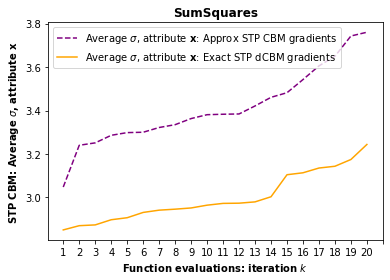

In [ ]:
### Visualise!

title = func
plt.figure()

plt.plot(approx_stddev, color = 'Purple', ls='--', label='Average $\sigma$, attribute $\mathbf{x}$: Approx STP CBM gradients')
plt.plot(exact_stddev, color = 'Orange', ls='-', label='Average $\sigma$, attribute $\mathbf{x}$: Exact STP dCBM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('Function evaluations: iteration $\it{k}$', weight = 'bold')
plt.ylabel('STP CBM: Average $\sigma$, attribute $\mathbf{x}$', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show() #visualize!
